In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import datajoint as dj

In [3]:
schema = dj.schema('trasfer')

Connecting root@localhost:3306


In [6]:
@schema
class Source(dj.Lookup):
    definition = """
    name : char(12)
    ---
    image_url : varchar(255)
    """
    
    contents = (
        ('mona', 'https://upload.wikimedia.org/wikipedia/commons/5/55/Mona_Lisa_headcrop.jpg'),
        ('starry', 'https://upload.wikimedia.org/wikipedia/commons/f/f2/VangoghStarry-night2.jpg'),
        ('eye', 'https://upload.wikimedia.org/wikipedia/commons/4/42/GreenEye3.jpg'),
        ('sunflower', 'https://upload.wikimedia.org/wikipedia/commons/e/e5/Sonnenblume_Helianthus_1.JPG'),
        ('roma', 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Foro_di_Cesare_a_Roma.jpg/1024px-Foro_di_Cesare_a_Roma.jpg')
    )

In [7]:
Source()

*name         image_url     
+-----------+ +------------+
eye           https://upload
mona          https://upload
roma          https://upload
starry        https://upload
sunflower     https://upload
 (Total: 5)

In [8]:
import requests
import os

@schema
class Image(dj.Imported):
    definition = """
    -> Source
    ---
    image : longblob
    """
    
    def make(self, key):
        url = (Source & key).fetch1('image_url')
        tempfile = 'image.tmp'
        with open(tempfile, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, image=plt.imread(tempfile)))
        os.unlink(tempfile)

In [9]:
Image.populate(display_progress=True)

Image: 0it [00:00, ?it/s]


In [10]:
Image() * Source

*name         image      image_url     
+-----------+ +--------+ +------------+
eye           =BLOB=     https://upload
mona          =BLOB=     https://upload
roma          =BLOB=     https://upload
starry        =BLOB=     https://upload
sunflower     =BLOB=     https://upload
 (Total: 5)

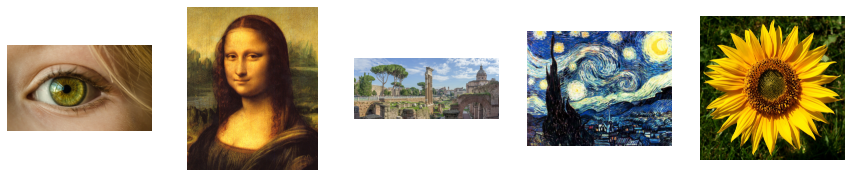

In [11]:
fig, ax = plt.subplots(1, len(Image()), figsize=(len(Image())*3,3))
for a, img in zip(ax, Image.fetch('image')):
    a.imshow(img)
    a.axis(False)

In [12]:
import numpy as np
import cv2
import imutils

In [13]:
@schema
class Crop(dj.Computed):
    definition = """
    -> Image
    ---
    cropped_image : longblob
    """
    
    def make(self, key):
        img = (Image & key).fetch1('image')
        sz = min((img.shape[:2]))
        sz1 = (img.shape[0] - sz)//2
        sz2 = (img.shape[1] - sz)//2
        img = imutils.resize(img[sz1:sz1+sz, sz2:sz2+sz], width=600, height=600)
        self.insert1(dict(key, cropped_image=img))

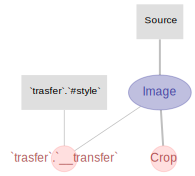

In [14]:
dj.Diagram(schema)

In [15]:
Crop.populate(display_progress=True)

Crop: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


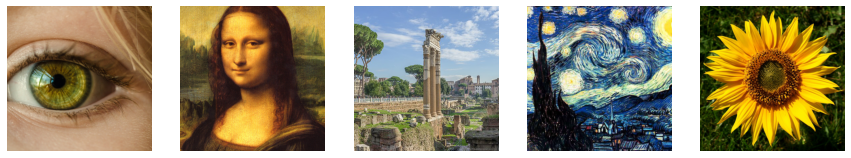

In [16]:
fig, ax = plt.subplots(1, len(Crop()), figsize=(len(Crop())*3,3))
for a, img in zip(ax, Crop.fetch('cropped_image')):
    a.imshow(img)
    a.axis(False)

In [17]:
@schema
class Style(dj.Lookup):
    definition = """
    style_name      : varchar(30)
    """
    contents = (['udnie'], ['la_muse'], ['starry_night'], ['mosaic'])

In [18]:
ls models

la_muse.t7  mosaic.t7  starry_night.t7  udnie.t7


In [19]:
image = Crop.fetch('cropped_image', limit=1)[0]

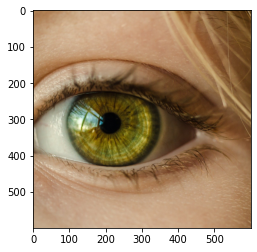

In [20]:
plt.imshow(image)

In [21]:
    net = cv2.dnn.readNetFromTorch('/home/ubuntu/StyleTransfer/notebooks/models/la_muse.t7')    
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # construct a blob from the image, set the input, and then perform a
    # forward pass of the network
    blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
                                 (103.939, 116.779, 123.680), swapRB=False, crop=False)
    net.setInput(blob)
    output = net.forward()

    # reshape the output tensor, add back in the mean subtraction, and
    # then swap the channel ordering
    output = output.reshape((3, output.shape[2], output.shape[3]))
    output[0] += 103.939
    output[1] += 116.779
    output[2] += 123.680
    output = output.transpose(1, 2, 0)
    output = np.clip(output, 0, 255)
    output= output.astype('uint8')

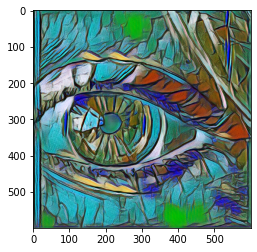

In [22]:
plt.imshow(output)

In [23]:
@schema
class Transfer(dj.Computed):
    definition = """
    -> Image
    -> Style
    ---
    art_image : longblob
    """
    
    def make(self, key):
        image = (Image & key).fetch1('image')
        style_name = (Style & key).fetch1('style_name')
        net = cv2.dnn.readNetFromTorch(f'/home/ubuntu/StyleTransfer/notebooks/models/{style_name}.t7')
        image = imutils.resize(image, width=800)
        (h, w) = image.shape[:2]

        # construct a blob from the image, set the input, and then perform a
        # forward pass of the network
        blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
                                     (103.939, 116.779, 123.680), swapRB=False, crop=False)
        net.setInput(blob)
        output = net.forward()

        # reshape the output tensor, add back in the mean subtraction, and
        # then swap the channel ordering
        output = output.reshape((3, output.shape[2], output.shape[3]))
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.680
        output = output.transpose(1, 2, 0)
        output = np.clip(output, 0, 255)
        output= output.astype('uint8')
        self.insert1(dict(key, art_image=output))
        

In [25]:
Transfer.populate(display_progress=True)

Transfer: 0it [00:00, ?it/s]


In [26]:
Transfer()

*name         *style_name    art_image 
+-----------+ +------------+ +--------+
eye           la_muse        =BLOB=    
mona          la_muse        =BLOB=    
roma          la_muse        =BLOB=    
starry        la_muse        =BLOB=    
sunflower     la_muse        =BLOB=    
eye           mosaic         =BLOB=    
mona          mosaic         =BLOB=    
roma          mosaic         =BLOB=    
starry        mosaic         =BLOB=    
sunflower     mosaic         =BLOB=    
eye           starry_night   =BLOB=    
mona          starry_night   =BLOB=    
   ...
 (Total: 20)

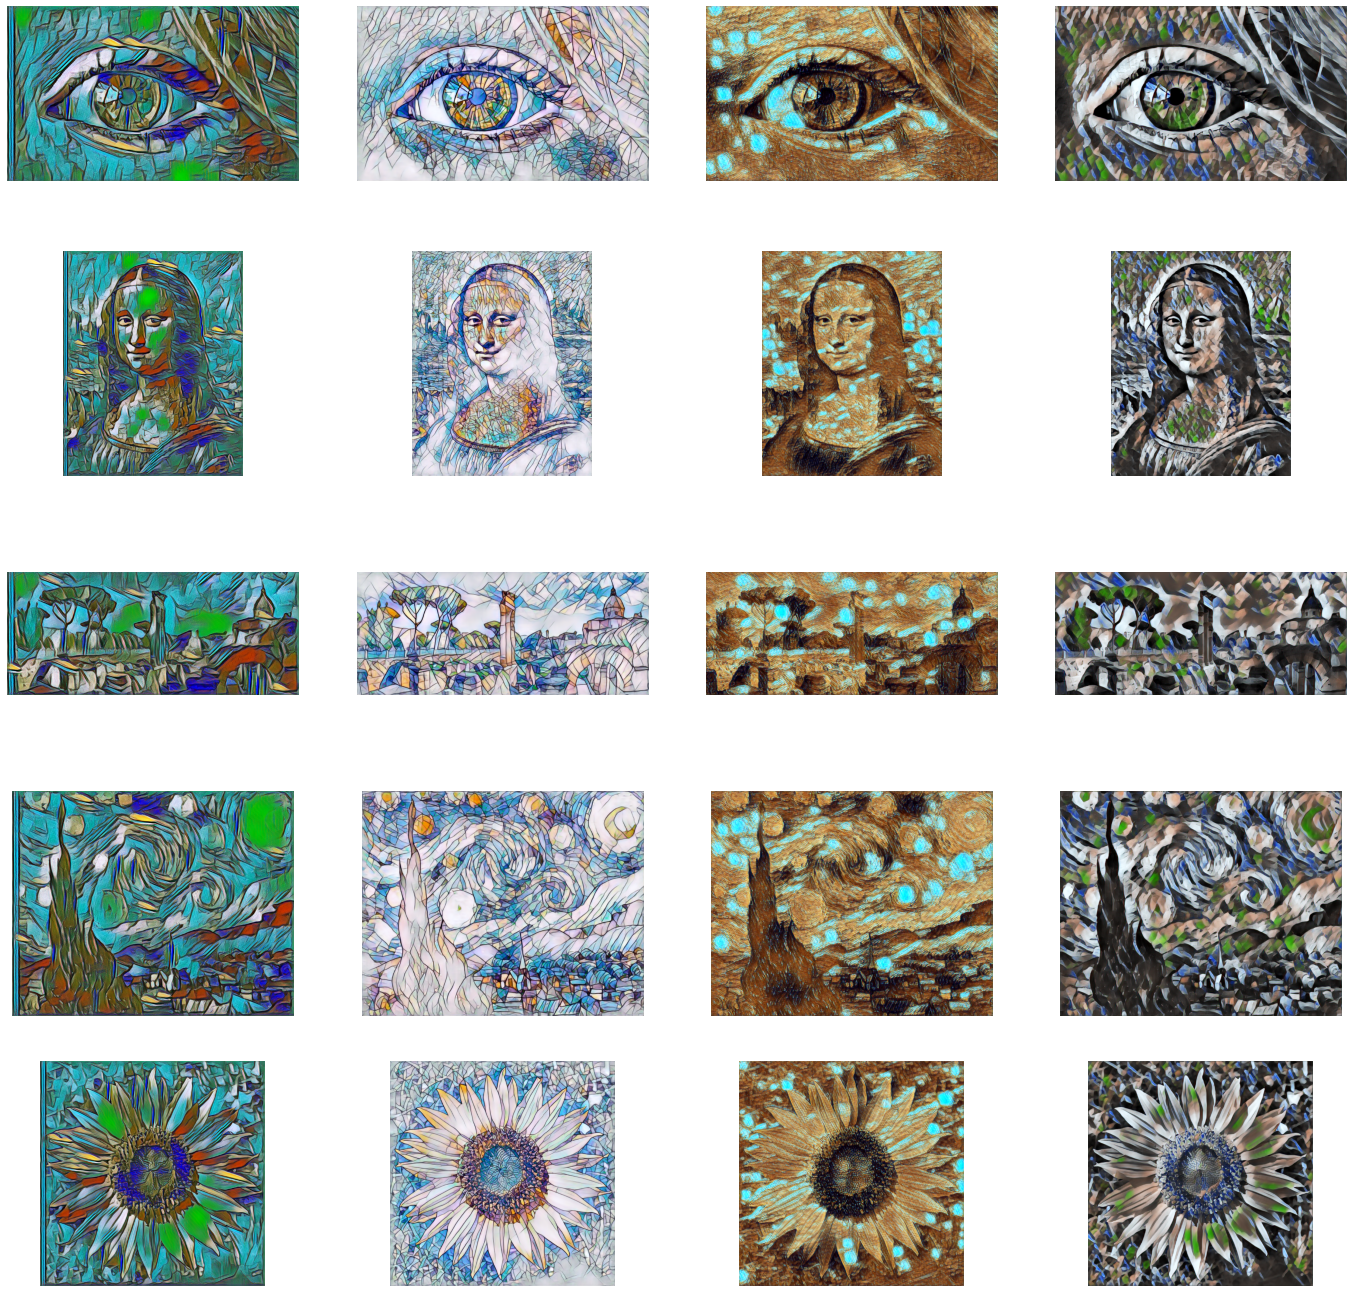

In [27]:
fig, axx = plt.subplots(5, 4, figsize=(24, 24))

for ax, img in zip(axx.flatten(), Transfer.fetch('art_image')):
    ax.imshow(img)
    ax.axis(False)

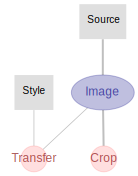

In [28]:
dj.Diagram(schema)

In [29]:
Image.populate(display_progress=True)
Transfer.populate(display_progress=True)

Image: 0it [00:00, ?it/s]
Transfer: 0it [00:00, ?it/s]
